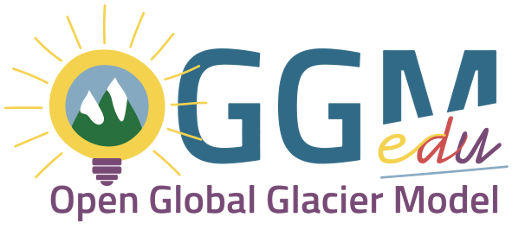

# Mass balance gradients (MBG)

Goals of this notebook:


- The student will be able to explain the terms: mass balance gradient, equilibrium state and response time.
- The student will be able to compute different MBGs with OGGM.
- The student will be able to compute response times for different equilibirum line altitudes.

If the concept of mass balance is completely new to you, have a short read about it [here](http://www.antarcticglaciers.org/glacier-processes/introduction-glacier-mass-balance/) up to the paragraph "*So what is Glacier Mass Balance?*". In this notebook we will set-up a few simple runs to understand which characteristics of glaciers come along with different MBGs. So we will look closer on the topics volume and response time.

First, we have to import all needed modules:

In [1]:
# The commands below are just importing the necessary modules and functions
# Plot defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)  # Default plot size
# Scientific packages
import numpy as np
import pandas as pd

# Constants
from oggm import cfg
cfg.initialize()
# OGGM models
from oggm.core.massbalance import LinearMassBalance
from oggm.core.flowline import FluxBasedModel, RectangularBedFlowline, TrapezoidalBedFlowline, ParabolicBedFlowline
# There are several solvers in OGGM core. We use the default one for this experiment
from functools import partial
FlowlineModel = partial(FluxBasedModel, min_dt=0, cfl_number=0.01)

# OGGM Edu helper functions
import oggm_edu as edu

2019-05-16 18:09:43: oggm.cfg: Using configuration file: C:\Program Files\Miniconda3\envs\oggm_env\lib\site-packages\oggm\params.cfg


We set-up a simple model with a linear bedrock. (We do similiar steps like in [flowline_model](http://edu.oggm.org/en/latest/notebooks_flowline_intro.html#glacier-flowline-modelling) to generate a set-up for our experiment.)

In [2]:
# This is the bed rock, linearily decreasing from 3400m altitude to 1400m, in 200 steps
nx = 200
bed_h = np.linspace(3400, 1400, nx)
# At the begining, there is no glacier so our glacier surface is at the bed altitude
surface_h = bed_h
# Let's set the model grid spacing to 100m 
map_dx = 100
# calculate the corresponding distance along the glacier (from the top)
distance_along_glacier = np.linspace(0,nx, nx) *0.1 # in km 
# The units of widths is in "grid points", i.e. 3 grid points = 300 m in our case
widths = np.zeros(nx) + 3.
# Define our bed
init_flowline = RectangularBedFlowline(surface_h=surface_h, bed_h=bed_h, widths=widths, map_dx=map_dx)

## Changing the mass balance gradient (MBG)
The MBG is defined as the change of the mass balance with altitude.[¹](#References) It depends strongly on the climate.[²](#References) 

Let's have a look at some examples:

In [3]:
# Define the MBGs we want to compare: (we worked with grad=4 in the 
# glacier flowline modelling notebook)
# We will calculate models with the MBGs: 0.3, 4 and 15 (These numbers can be found for real glaciers.) 
grad = [0.3, 4, 15]
# Define the time period for which the glacier should be calculated:
years = 300

In [4]:
# In the following lists intermediate steps of the models will be saved
mb_models = []
annual_mb = []
# here the "final" models will be saved
models = []
# Colors for the graphs
colors = ['C1', 'C3', 'C5'] 
# equilibrium line altitude (ELA)
ELA = 3000

for k, gradient in enumerate(grad):
    # Calculation of the mass balance models for each gradient 
    a = LinearMassBalance(ELA, grad=gradient)
    mb_models.append(a)
    # Calculation of the annual mass balance along the glacier profile
    annual_mb.append(a.get_annual_mb(surface_h) * cfg.SEC_IN_YEAR)
    # The models require the initial glacier bed, a mass balance model, and an initial time (the year y0)
    models.append(FlowlineModel(init_flowline, mb_model=a, y0=0.))
    # First, look at the state of the glacier models after the chosen amount of years
    models[k].run_until(years)

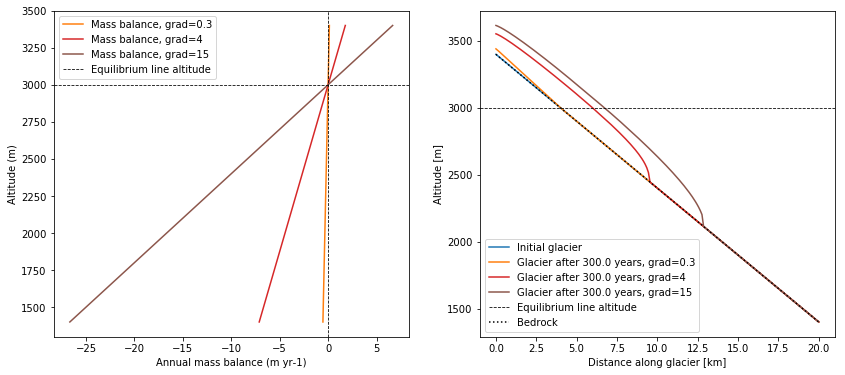

In [5]:
# Plot the results
plt.figure(figsize=[14,6])

plt.subplot(121)
# Annual mass balance
for k, ann_mb in enumerate(annual_mb):
    plt.plot(ann_mb, bed_h, color=colors[k], label='Mass balance, grad='+ str(grad[k]))
# Add ELA, where mass balance = 0:
plt.axhline(y=ELA, color='k', linestyle='--', linewidth=0.8, label='Equilibrium line altitude')
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel('Annual mass balance (m yr-1)')
plt.ylabel('Altitude (m)')
plt.legend(loc='best');

plt.subplot(122)
# Plot the initial conditions first:
plt.plot(distance_along_glacier, init_flowline.surface_h, label='Initial glacier')
# Get the modelled flowline (model.fls[-1]) and plot its new surface
for k, model in enumerate(models):
    plt.plot(distance_along_glacier, model.fls[-1].surface_h, label='Glacier after {} years, '.format(model.yr) + 'grad=' + str(grad[k]), color=colors[k])
# Add ELA:
plt.axhline(y=ELA, color='k', linestyle='--', linewidth=0.8, label='Equilibrium line altitude')
# Add the bedrock:
edu.plot_xz_bed(distance_along_glacier, bed_h)

In the left graphic we see that higher gradients show shallower slopes. The model with the highest gradient (purple line) experiences the highest ablation and accumulation. Therefore it shows the longest und thickest glacier after the chosen amount of calculated years (compare the right graphic). As the models are all calculated the same time span we can conclude that a high gradient leads to faster growing of a glacier. What do you think: where do we find glaciers with high MBGs?

You find a short explanation in this [paragraph](http://www.antarcticglaciers.org/modern-glaciers/introduction-glacier-mass-balance/#SECTION_3).

## Equilibrium state 

Glaciers change their geometry to adapt to the climate.³ If the climate stayed constant for a while, after a certain time glaciers would reach an equilibrium state, where ablation = accumulation.[⁴](#References) 

Now we will look how fast our glacier models with different gradients reach this state and compare their shapes:

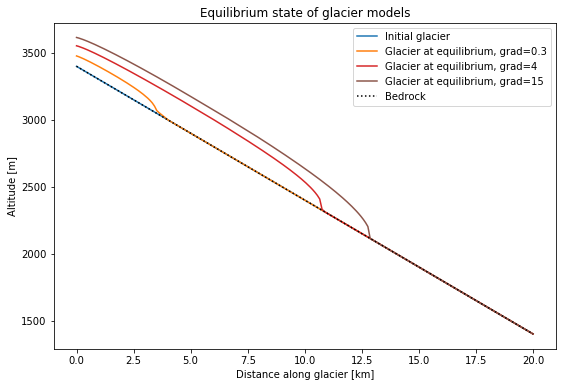

In [6]:
# Plot it
plt.figure(figsize=[9,6])
# Plot the initial conditions first:
plt.plot(distance_along_glacier, init_flowline.surface_h, label='Initial glacier')

for k, model in enumerate(models):
    # Run the different glacier models until they reach an equilibrium state
    model.run_until_equilibrium(rate=0.006)
    # Get the modelled flowline (model.fls[-1]) and plot its new surface
    plt.plot(distance_along_glacier, model.fls[-1].surface_h, 
             label='Glacier at equilibrium, grad=' + str(grad[k]), 
             color=colors[k])
plt.title('Equilibrium state of glacier models')
    # Add the bedrock:
edu.plot_xz_bed(distance_along_glacier, bed_h)

The different models reach their equilibrium state after different amounts of years. What does the figure show us? Which glacier is the thickest and longest? Let's look at specific numbers: 

In [7]:
# Create lists with different properties of the glacier models
volume = []
area = []
length = []
year = []

for model in models:
    year.append(model.yr)
    volume.append(model.volume_km3)
    length.append(model.length_m)
    area.append(model.area_km2)

# Create a table with the properties of the glacier models
dic = {'gradient': grad, 'year': year, 'volume': volume, 'area': area, 'length': length}
table = pd.DataFrame.from_dict(dic)
table

,gradient,year,volume,area,length
0,0.3,985.0,0.095133,1.20,4000.0
1,4.0,370.0,0.590061,3.24,10800.0
2,15.0,305.0,0.940162,3.84,12800.0


### Volume

Let's have a close look at the volume of the glacier models:

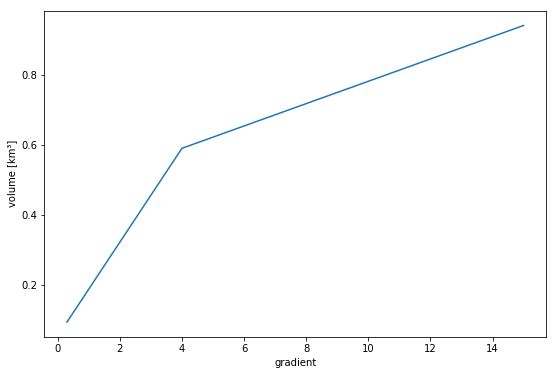

In [8]:
# Plot the volume depending on the gradient
plt.figure(figsize=[9,6])
plt.plot(table['gradient'], table['volume'])
plt.xlabel('gradient')
plt.ylabel('volume [km³]');

We will add some more values. Be patient, the calculation will take a little bit longer.

In [9]:
# We will calculate models with the MBGs: 1 to 19 with stepsize 2
grad = list(range(1,21,2))
# In the following lists the intermediate steps of the models will be saved
mb_models = []
annual_mb = []
# here the "final" models will be saved
models = []
                               
for k, gradient in enumerate(grad):
    a = LinearMassBalance(3000, grad=gradient)
    mb_models.append(a)
    # Calculation of the annual mass balance along the glacier profile
    annual_mb.append(a.get_annual_mb(surface_h) * cfg.SEC_IN_YEAR)
    # The models require the initial glacier bed, a mass balance model, and an initial time (the year y0)
    models.append(FlowlineModel(init_flowline, mb_model=a, y0=0.))
    # First, look at the state of the glacier models after 300 years
    models[k].run_until_equilibrium(rate=0.006)

In [10]:
# create lists with different properties of the glacier models
volume = []
area = []
length = []
year = []

for model in models:
    year.append(model.yr)
    volume.append(model.volume_km3)
    length.append(model.length_m)
    area.append(model.area_km2)

dic = {'gradient': grad, 'year': year, 'volume': volume, 'area': area, 'length': length}
table = pd.DataFrame.from_dict(dic)
table

,gradient,year,volume,area,length
0,1,805.0,0.315285,2.37,7900.0
1,3,440.0,0.528253,3.09,10300.0
2,5,320.0,0.638614,3.33,11100.0
3,7,255.0,0.716221,3.48,11600.0
4,9,215.0,0.779416,3.57,11900.0
5,11,190.0,0.835518,3.66,12200.0
6,13,170.0,0.883354,3.72,12400.0
7,15,155.0,0.926566,3.78,12600.0
8,17,140.0,0.963063,3.84,12800.0
9,19,130.0,0.999428,3.87,12900.0


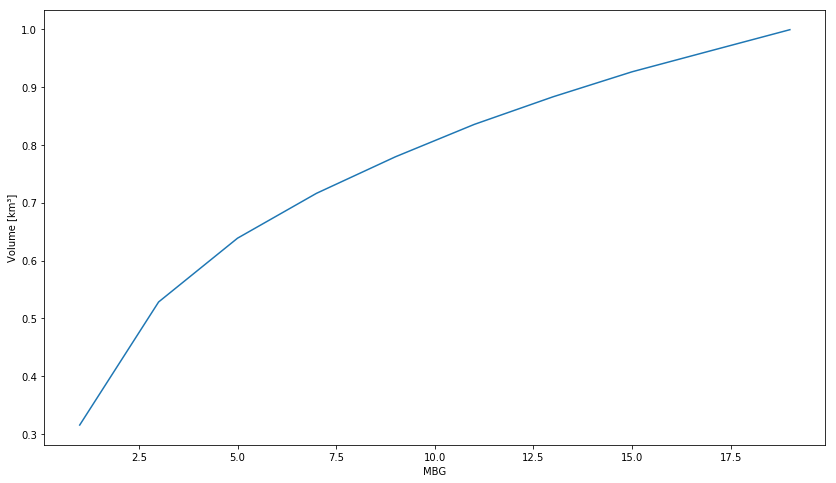

In [11]:
# Plot it
plt.figure(figsize=[14,8])
plt.plot(table['gradient'], table['volume'])
plt.xlabel('MBG')
plt.ylabel('Volume [km³]');

## Response time
The glacier response time is the period of time a glacier needs to adjust its geometry to changes in mass balance caused by climate change and reach a new equilibrium state. There are a some slightly different definitions for its calculation. In this notebook we will use the definition according to Oerlemans (formula below).[⁵](#References)


We will now compare the response times of glaciers with different MBGs. Let's simulate a climate change by changing the equilibrium line altitude for the three glacier models calculated before:

In [12]:
# Initialization of the models used before:
grad = [0.3, 4, 15]
mb_models = []
annual_mb = []
# here the "final" models will be saved
models = []
# Colors for the graphs
colors = ['C1', 'C3', 'C5'] 
# equilibrium line altitude (ELA)
ELA = 3000
for k, gradient in enumerate(grad):
    # Calculation of the mass balance models for each gradient 
    a = LinearMassBalance(ELA, grad=gradient)
    mb_models.append(a)
    # The models require the initial glacier bed, a mass balance model, and an initial time (the year y0)
    models.append(FlowlineModel(init_flowline, mb_model=a, y0=0.))
    # First, look at the state of the glacier models after the chosen amount of years
    models[k].run_until_equilibrium(rate=0.006)

Equilibrium line altitude for the "new climate":

In [13]:
# First we change the mass balance model, ELA decreases 
# (what could this tell us about the climate?)
mb_model1 = LinearMassBalance(2800, grad=0.3)

The next step is the calculation of the response time. Here we use the [volume response time](https://www.tandfonline.com/doi/pdf/10.1080/00040851.1997.12003238?needAccess=true), which is e-folding, according to Oerlemans:[⁵](#References)
$$\tau = t \left(V=V_2 - \frac{V_2 - V_1}{e}\right)$$
Hereby, the volumes correspond to the glacier volumes at steady state for the reference volume $V_1$ and the volume $V_2$ adapted to the new climate.

In [14]:
# With the following function you can calculate the response time in years
# (the reference model has to be in equilibrium state)
models[0].run_until_equilibrium(rate=0.006)
response_time_1, model1_eq = edu.response_time_vol(models[0], mb_model1)
print('The response time of model 1 is {} years.'.format(response_time_1))

The response time of model 1 is 320.0 years.


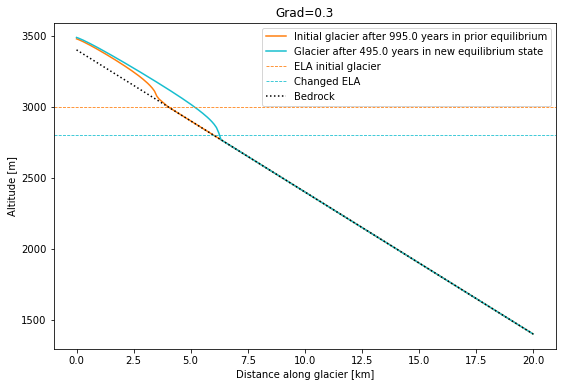

In [15]:
plt.figure(figsize=(9,6))
# Get the modelled flowline (model.fls[-1]) and plot its new surface
plt.plot(distance_along_glacier, models[0].fls[-1].surface_h, label='Initial glacier after {} years in prior equilibrium'.format(models[0].yr), color='C1')
plt.plot(distance_along_glacier, model1_eq.fls[-1].surface_h, label='Glacier after {} years in new equilibrium state'.format(model1_eq.yr), color='C9')

# Plot the equilibrium line altitudes
plt.axhline(mb_models[0].ela_h, linestyle='--', color='C1', linewidth=0.8, label='ELA initial glacier')
plt.axhline(mb_model1.ela_h, linestyle='--', color='C9', linewidth=0.8, label='Changed ELA')
plt.title('Grad={}'.format(mb_model1.grad))

# Add the bedrock and axes lables:
edu.plot_xz_bed(x=distance_along_glacier, bed = bed_h)

Now we do the same for the other two examples:

In [16]:
# change Ela
mb_model2 = LinearMassBalance(2800, grad=4)
mb_model3 = LinearMassBalance(2800, grad=15)
# Calculate the response time in years
models[1].run_until_equilibrium(rate=0.006)
response_time_2, model2_eq = edu.response_time_vol(models[1], mb_model2)
print('The response time of model 2 is {} years.'.format(response_time_2))
models[2].run_until_equilibrium(rate=0.006)
response_time_3, model3_eq = edu.response_time_vol(models[2], mb_model3)
print('The response time of model 3 is {} years.'.format(response_time_3))

The response time of model 2 is 65.0 years.
The response time of model 3 is 25.0 years.


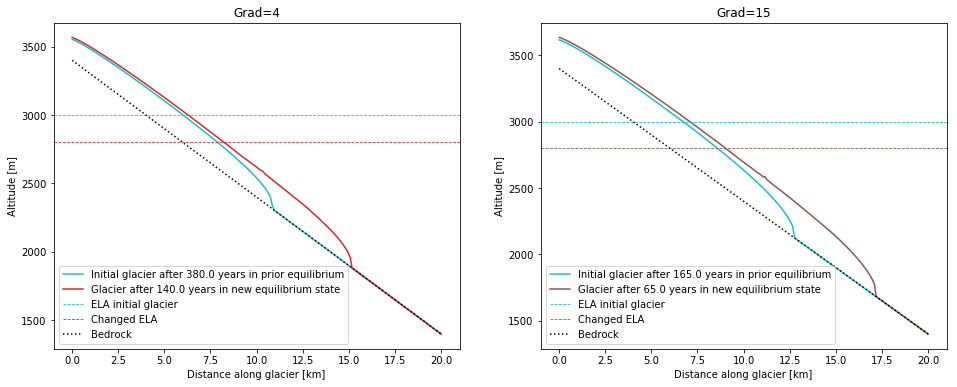

In [17]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)

# Get the modelled flowline (model.fls[-1]) and plot its new surface
plt.plot(distance_along_glacier, models[1].fls[-1].surface_h, label='Initial glacier after {} years in prior equilibrium'.format(models[1].yr), color='C9')
plt.plot(distance_along_glacier, model2_eq.fls[-1].surface_h, label='Glacier after {} years in new equilibrium state'.format(model2_eq.yr), color='C3')

# Plot the equilibrium line altitudes
plt.axhline(mb_models[1].ela_h, linestyle='--', color='C9', linewidth=0.8, label='ELA initial glacier')
plt.axhline(mb_model2.ela_h, linestyle='--', color='C3', linewidth=0.8, label='Changed ELA')
plt.title('Grad={}'.format(mb_model2.grad))
# Add the bedrock and axes lables:
edu.plot_xz_bed(x=distance_along_glacier, bed = bed_h)

plt.subplot(1,2,2)

# Get the modelled flowline (model.fls[-1]) and plot its new surface
plt.plot(distance_along_glacier, models[2].fls[-1].surface_h, label='Initial glacier after {} years in prior equilibrium'.format(models[2].yr), color='C9')
plt.plot(distance_along_glacier, model3_eq.fls[-1].surface_h, label='Glacier after {} years in new equilibrium state'.format(model3_eq.yr), color='C5')

# Plot the equilibrium line altitudes
plt.axhline(mb_models[2].ela_h, linestyle='--', color='C9', linewidth=0.8, label='ELA initial glacier')
plt.axhline(mb_model3.ela_h, linestyle='--', color='C5', linewidth=0.8, label='Changed ELA')
plt.title('Grad={}'.format(mb_model3.grad))

# Add the bedrock and axes lables:
edu.plot_xz_bed(x=distance_along_glacier, bed = bed_h)

Compare the response times. From our results we can only conclude a trend. Glaciers with small MBG need more time to adjust to climate changes than glaciers with high MBGs (under the condition that the changes are similiar). Glaciers with gradients as high as the third model need only a few years to adjust to the climate (compare Franz Josef glacier in New Zealand[⁶](#References)).[⁷](#References) The response time of glaciers with low gradients is in reality much higher than 200 years, actually around 2000 years.  In general, we have to consider that the response time depends also on other features like the glacier-type,  size, bed slope and average surface elevation.[⁴](#References)


## References

¹ Rasmussen, L. A., & Andreassen, L. M. (2005). Seasonal mass-balance gradients in Norway. *Journal of Glaciology*, 51(175), 601-606.

² Oerlemans, J., & Fortuin, J. P. F. (1992). Sensitivity of glaciers and small ice caps to greenhouse warming. *Science, 258(5079)*, 115-117.

³ Oerlemans, J. (2001). *Glaciers and climate change*. CRC Press.

⁴ Encyclopedia of snow, ice and glaciers, V.P. Singh, P. Singh, and U.K. Haritashya, Editors. 2011, Springer: Dordrecht, The Netherlands. p. 245-256.

⁵ Oerlemans, J. (1997). Climate sensitivity of Franz Josef Glacier, New Zealand, as revealed by numerical modeling. *Arctic and Alpine Research*, 29(2), 233-239.

⁶ Anderson, B., Lawson, W., & Owens, I. (2008). Response of Franz Josef Glacier Ka Roimata o Hine Hukatere to climate change. Global and Planetary Change, 63(1), 23-30.

⁷ Cuffey, K.M. & Paterson, W.S.B. *The Physics of Glaciers, 4th edition*, 704 (Academic Press, 2010).


## What's next?
[Back to table of contents](welcome.ipynb)